# langgrap

In [4]:
from src.llm.llm_factory import LLMFactory

llm = LLMFactory.create_llm()

In [ ]:
# langchain 做法
from langchain_community.chat_models import ChatTongyi
# 构建阿里云百炼大模型客户端
llm.invoke("你是谁？能帮我解决什么问题？")

In [5]:
# langgraph 做法
from langgraph.prebuilt import create_react_agent
from langchain.tools import tool
@tool
def get_weather(city: str) -> str:
    """获取某个城市的天气情况"""
    return f"{city}今天天气热，39度"

agent = create_react_agent(
    model = llm,
    tools = [get_weather],
    prompt = "你是一个友好的小帮手"
)


In [13]:
result = agent.invoke({
    "messages": [{"role": "user", "content": "请问北京的天气怎么样？"}]
})

In [14]:
print(result.values())

dict_values([[HumanMessage(content='请问北京的天气怎么样？', additional_kwargs={}, response_metadata={}, id='57c1c797-9985-41ad-a7fc-1ec68b8ae594'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_0_c4edc053-4c63-4c12-8a39-41ced39ab5a2', 'function': {'arguments': '{"city":"北京"}', 'name': 'get_weather'}, 'type': 'function', 'index': 0}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 106, 'total_tokens': 125, 'completion_tokens_details': None, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 64}, 'prompt_cache_hit_tokens': 64, 'prompt_cache_miss_tokens': 42}, 'model_name': 'deepseek-chat', 'system_fingerprint': 'fp_8802369eaa_prod0623_fp8_kvcache', 'id': 'b78df58e-7ba3-4854-948c-c2414fdc0dc5', 'service_tier': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--597f09a7-e72a-4885-a718-0a987f4f9fa7-0', tool_calls=[{'name': 'get_weather', 'args': {'city': '北京'}, 'id': 'call_0_c4edc053-4c63-4c12-8a39-41ce

这里stream_mode有三种选项：
- updates：流式输出每个工具调用的每个步骤。
- messages：流式输出大语言模型回复的Token。
- values：一次拿到所有的chunk。默认值。
- custom：自定义输出。主要是可以在工具内部使用get_stream_writer获取输入流，添加自定义的内容。
关于流式输出的这几种选项，在后面结合Graph，会体现出更大的作用。

In [17]:
for chunk in agent.stream(
        {"messages": [{"role": "user", "content": "你是谁能帮我解决什么问题？"}]},
        stream_mode = "messages"
):
    print(chunk(0))
    print("\n")

(AIMessageChunk(content='', additional_kwargs={}, response_metadata={}, id='run--ef5b139f-e234-4514-bc46-f4df8bc7e944'), {'langgraph_step': 1, 'langgraph_node': 'agent', 'langgraph_triggers': ('branch:to:agent',), 'langgraph_path': ('__pregel_pull', 'agent'), 'langgraph_checkpoint_ns': 'agent:aadc7394-5352-f191-8554-db251ad18d9d', 'checkpoint_ns': 'agent:aadc7394-5352-f191-8554-db251ad18d9d', 'ls_provider': 'openai', 'ls_model_name': 'deepseek-chat', 'ls_model_type': 'chat', 'ls_temperature': 0.0})


(AIMessageChunk(content='我是一个', additional_kwargs={}, response_metadata={}, id='run--ef5b139f-e234-4514-bc46-f4df8bc7e944'), {'langgraph_step': 1, 'langgraph_node': 'agent', 'langgraph_triggers': ('branch:to:agent',), 'langgraph_path': ('__pregel_pull', 'agent'), 'langgraph_checkpoint_ns': 'agent:aadc7394-5352-f191-8554-db251ad18d9d', 'checkpoint_ns': 'agent:aadc7394-5352-f191-8554-db251ad18d9d', 'ls_provider': 'openai', 'ls_model_name': 'deepseek-chat', 'ls_model_type': 'chat', 'ls_temper

三、增加Tools工具调用

Tools工具机制是大语言模型中的一个重要机制，它可以让大模型调用外部工具，从而实现更加复杂的功能。通常，一个完整的工具调用流程需要以下几个步骤：
1. 客户端定义工具类，实现工具的功能。
2. 客户端请求大语言模型，带上问题以及工具的描述信息。
3. 大语言模型综合判断问题，并决定是否调用工具。
4. 如果大语言模型判断需要使用工具，就会向客户端返回一个带有tool_calls工具调用信息的AIMessage。
5. 客户端根据工具调用信息，调用工具，并将结果返回给大语言模型。
6. 大语言模型根据工具调用的结果，生成最终的回答。

使用LangChain，我们需要实现完整的流程。而使用LangGraph后，工具成了Agent的标配。只需要定义工具类，Agent中会自行完成工具调用的流程。

In [21]:
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode

# 定义工具 return_direct=True 表示直接返回工具的结果 不用再返回给大模型做渲染
@tool("divide_tool", return_direct=True)
def divide(a: int, b: int) -> float:
    """"计算两个整数的除法。
    Args:
        a (int): 除数
        b (int): 被除数"""
    # 自定义错误
    if b == 1:
        raise ValueError("除数不能为1")
    return a / b

print(divide.name)
print(divide.description)
print(divide.args)
# 定义工具调用错误处理函数
def handle_tool_error(error: Exception) -> str:
    """"处理工具调用错误。
    Args:
        error (Exception): 工具调用错误"""
    if isinstance(error, ValueError):
        return "除数为1没有意义，请重新输入一个除数和被除数。"
    elif isinstance(error, ZeroDivisionError):
        return "除数不能为0，请重新输入一个除数和被除数。"
    return f"工具调用错误: {error}"
tool_node = ToolNode(
    [divide],
    handle_tool_errors=handle_tool_error
)
agent_with_error_handler = create_react_agent(
    model=llm,
    tools=tool_node
)

divide_tool
"计算两个整数的除法。
    Args:
        a (int): 除数
        b (int): 被除数
{'a': {'title': 'A', 'type': 'integer'}, 'b': {'title': 'B', 'type': 'integer'}}


In [22]:
result = agent_with_error_handler.invoke({"messages": [{"role": "user", "content": "10除以1等于多少"}]})
# 打印最后的返回结果
print(result)
print(result["messages"][-1].content)

{'messages': [HumanMessage(content='10除以1等于多少', additional_kwargs={}, response_metadata={}, id='634d6c60-afe1-4c86-bef0-326cc91ed4e2'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_0_99ce4b12-1a14-450a-b6da-50645d0440ba', 'function': {'arguments': '{"a":10,"b":1}', 'name': 'divide_tool'}, 'type': 'function', 'index': 0}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 31, 'prompt_tokens': 148, 'total_tokens': 179, 'completion_tokens_details': None, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 128}, 'prompt_cache_hit_tokens': 128, 'prompt_cache_miss_tokens': 20}, 'model_name': 'deepseek-chat', 'system_fingerprint': 'fp_8802369eaa_prod0623_fp8_kvcache', 'id': '723d090e-ab9f-43f7-a127-f8bfe5824946', 'service_tier': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--babdcbc7-b528-46c2-bedb-152544c069ba-0', tool_calls=[{'name': 'divide_tool', 'args': {'a': 10, 'b': 1}, 'id': 'call_0_99ce4b12-1a14-450a-b6da-

在LangChain中，我们需要自行定义ChatMessageHistory，并且自行保存每一轮的消息记录，然后在调用大模型时，将其作为参数传入。
LangGraph中，实现消息记录的流程，也完整的封装到了Agent当中。
LangGraph将消息记忆分为了短期记忆与长期记忆。
短期记忆是指Agent内部的记忆，用于当前对话中的历史记忆信息。LangGraph将他封装成Checkpoint。
长期记忆是指Agent外部的记忆，用第三方存储长久的保存用户级别或者应用级别的聊天信息。LangGraph将它封装成Store。


对于记忆管理，我认为LangGraph的管理方式或许比具体实现更有参考价值。
在具体实现时，LangGraph都默认提供了InMemorySaver和InMemoryStore，也同样都可以转移到其他外部存储当中。不过，短期记忆通常是代表那些会话级别的小内存，而长期记忆通常是代表那些用户级别或者应用级别的大内存。短期记忆的内存比较紧张，所以需要更频繁的清理内存，并对已有的消息记录进行总结，从而减少内存占用。而长期记忆的内存比较充足，所以不太需要频繁的清理内存。更需要关注的，是如何对已有的消息进行检索。


## 4.1 短期记忆 CheckPoint

在LangGraph的Agent中，只需要指定checkpointer属性，就可以实现短期记忆。具体传入的属性需要是BaseCheckpointSaver的子类。

LangGraph中默认提供了InMemorySaver，用于将短期记忆信息保存在内存中。当然，也可以采用Redis、SQLite等第三方存储来实现长期记忆。不过当前版本的LangGraph并没有提供具体的实现，需要实现。（如果不会写，交给AI）

另外，使用checkpointer时，需要制定一个单独的thread_id来区分不同的对话。

In [23]:
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import InMemorySaver
# 存在内存中
checkpointer = InMemorySaver()
def get_weather(city: str) -> str:
    """获取某个城市的天气"""
    return f"城市: {city}, 天气一直都是晴天！"
agent = create_react_agent(
    model=llm,
    tools=[get_weather],
    checkpointer=checkpointer
)
# Run the agent
config = {
    "configurable": {
        "thread_id": "1"
    }
}
cs_response = agent.invoke(
    {"messages": [{"role": "user", "content": "长沙天气怎么样？"}]},
    config
)
print(cs_response)
# Continue the conversation using the same thread_id
bj_response = agent.invoke(
    {"messages": [{"role": "user", "content": "北京呢？"}]},
    config
)
print(bj_response)

{'messages': [HumanMessage(content='长沙天气怎么样？', additional_kwargs={}, response_metadata={}, id='bf06478f-9659-4e1d-86c3-597f01c279ad'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_0_427930ac-a4cf-4c7d-b213-4f7d79a21cae', 'function': {'arguments': '{"city":"长沙"}', 'name': 'get_weather'}, 'type': 'function', 'index': 0}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 104, 'total_tokens': 123, 'completion_tokens_details': None, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}, 'prompt_cache_hit_tokens': 0, 'prompt_cache_miss_tokens': 104}, 'model_name': 'deepseek-chat', 'system_fingerprint': 'fp_8802369eaa_prod0623_fp8_kvcache', 'id': '46915694-1ef0-448d-a458-eb144a6f1a29', 'service_tier': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--dc092d74-78ca-4757-ba37-c354beffc956-0', tool_calls=[{'name': 'get_weather', 'args': {'city': '长沙'}, 'id': 'call_0_427930ac-a4cf-4c7d-b213-4f7d79a2

从结果可以看到，当前会话当中和大模型的每次交互记录，包括工具调用的信息，都保存在了短期记忆当中。
当然，目前的实现是保存在内存中，所以程序结束后就释放了。生产环境中，LangGraph建议是保存到外部存储当中，例如数据库、文件系统等。这样每次启动程序时，都可以从外部存储中加载历史记录。

短期记忆通常认为是比较紧张的，所以需要定期做清理，防止历史消息过多。
LangGraph的Agent中，提供了一个pre_model_hook属性，可以在每次调用大模型之前触发。通过这个hook，就可以来定期管理短期记忆。

LangGraph中管理短期记忆的方法主要有两种：
- Summarization 总结：用大模型的方式，对短期记忆进行总结，然后再把总结的结果作为新的短期记忆。
- Trimming 删除：直接把短期记忆中最旧的消息删除掉。

LangGraph提供了SummarizationNode函数，用于使用大模型的方式对短期记忆进行总结。

In [ ]:
from langmem.short_term import SummarizationNode
from langchain_core.messages.utils import count_tokens_approximately
from langgraph.prebuilt import create_react_agent
from langgraph.prebuilt.chat_agent_executor import AgentState
from langgraph.checkpoint.memory import InMemorySaver
from typing import Any

# 使用大模型对历史信息进行总结
summarization_node = SummarizationNode(
    token_counter=count_tokens_approximately,
    model=llm,
    max_tokens=384,
    max_summary_tokens=128,
    output_messages_key="llm_input_messages",
)

class State(AgentState):
    # 注意：这个状态管理的作用是为了能够保存上一次总结的结果。这样就可以防止每次调用大模型时，都要重新总结历史信息。
    # 这是一个比较常见的优化方式，因为大模型的调用是比较耗时的。
    context: dict[str, Any]
checkpointer = InMemorySaver()
agent = create_react_agent(
    model=llm,
    tools=[get_weather],
    pre_model_hook=summarization_node,
    state_schema=State,
    checkpointer=checkpointer,
)

In [ ]:
from langchain_core.messages.utils import (
    trim_messages,
    count_tokens_approximately
)
from langgraph.prebuilt import create_react_agent
# 另外，还提供了trim_messages函数，用于定期清理短期记忆。
# This function will be called every time before the node that calls LLM
def pre_model_hook(state):
    trimmed_messages = trim_messages(
        state["messages"],
        strategy="last",
        token_counter=count_tokens_approximately,
        max_tokens=384,
        start_on="human",
        end_on=("human", "tool"),
    )
    return {"llm_input_messages": trimmed_messages}
checkpointer = InMemorySaver()
agent = create_react_agent(
    model=llm,
    tools=[],
    pre_model_hook=pre_model_hook,
    checkpointer=checkpointer,
)

# 实现了基础的短期记忆管理后，LangGraph还提供了状态管理机制，用于保存处理过程中的中间结果。而且，这些状态数据，还可以在Tools工具中使用。

In [ ]:
from typing import Annotated
from langgraph.prebuilt import InjectedState, create_react_agent
from langgraph.prebuilt.chat_agent_executor import AgentState
from langchain_core.tools import tool
# 定义状态管理，  这个可以在不同的agents 之间传递
class CustomState(AgentState):
    user_id: str

@tool(return_direct=True)
def get_user_info(
        state: Annotated[CustomState, InjectedState]
) -> str:
    """查询用户信息。"""
    user_id = state["user_id"]
    return "user_123用户的姓名楼兰。" if user_id == "user_123" else "未知用户"

agent = create_react_agent(
    model=llm,
    tools=[get_user_info],
    state_schema=CustomState,
)

agent.invoke({
    "messages": "查询用户信息",
    "user_id": "user_123"
})

## 4.2 长期记忆
长期记忆通常认为是比较充足的记忆空间，因此使用时，可以比短期记忆更加粗犷，不太需要实时关注内存空间大小。
至于使用方式，和短期记忆差不太多。主要是通过Agent的store属性指定一个实现类就可以了。
与短期记忆最大的区别在于，短期记忆通过thread_id来区分不同的对话，而长期记忆则通过namespace来区分不同的命名空间。

In [29]:
from langchain_core.runnables import RunnableConfig
from langgraph.config import get_store
from langgraph.prebuilt import create_react_agent
from langgraph.store.memory import InMemoryStore
from langchain_core.tools import tool
# 定义长期存储
store = InMemoryStore()
# 添加一些测试数据。users是命名空间，user_123是key，后面的JSON数据是value
store.put(
    ("users", ),
    "user_123",
    {
        "name": "楼兰",
        "age": "33",
    }
)
# 定义工具
@tool(return_direct=True)
def get_user_info(config: RunnableConfig) -> str:
    """查找用户信息"""
    # 获取长期存储。获取到了后，这个存储组件可读也可写
    store = get_store()
    # store.put(
    #     ("users",),
    #     "user_456",
    #     {
    #         "name": "楼兰",
    #         "age": "33",
    #     }
    # )
    # 获取配置中的用户ID
    user_id = config["configurable"].get("user_id")
    user_info = store.get(("users",), user_id)
    return str(user_info.value) if user_info else "Unknown user"
agent = create_react_agent(
    model = llm,
    tools = [get_user_info],
    store = store,
)

# Run the agent
agent.invoke(
    {"messages": [{"role": "user", "content": "查找用户信息"}]},
    config={"configurable": {"user_id": "user_123"}}
)

{'messages': [HumanMessage(content='查找用户信息', additional_kwargs={}, response_metadata={}, id='39d91e50-909f-4c02-b2d5-0fecf528f437'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_0_cca41bbb-9e4c-4bfc-8e18-65ecc29268ca', 'function': {'arguments': '{}', 'name': 'get_user_info'}, 'type': 'function', 'index': 0}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 75, 'total_tokens': 91, 'completion_tokens_details': None, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 64}, 'prompt_cache_hit_tokens': 64, 'prompt_cache_miss_tokens': 11}, 'model_name': 'deepseek-chat', 'system_fingerprint': 'fp_8802369eaa_prod0623_fp8_kvcache', 'id': '62d55dcd-7376-4206-b9fd-81093d622bcc', 'service_tier': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--b095e982-6588-4865-bac8-a7144ff2393c-0', tool_calls=[{'name': 'get_user_info', 'args': {}, 'id': 'call_0_cca41bbb-9e4c-4bfc-8e18-65ecc29268ca', 'type': 'tool

# 五、Human-in-the-loop人类监督

这也是LangGraph的Agent中非常核心的一个功能。

在Agent的工作过程中，有一个问题是非常致命的，就是Agent可以添加Tools工具，但是要不要调用工具，却完全是由Agent自己决定的。这就会导致Agent在面对一些问题时，可能会出现错误的判断。为了解决这个问题，LangGraph提供了Human-in-the-loop的功能。在Agent进行工具调用的过程中，允许用户进行监督。这就需要中断当前的执行任务，等待用户输入后，再重新恢复任务。

> A human can review and edit the output from the agent before proceeding. This is particularly critical in applications where the tool calls requested may be sensitive or require human oversight.

在实现时，LangGraph提供了interrupt()方法添加人类监督。监督时需要中断当前任务，所以通常是和stream流式方法配合使用。

In [30]:
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.types import interrupt
from langgraph.prebuilt import create_react_agent
from langchain_core.tools import tool

@tool(return_direct=True)
def book_hotel(hotel_name: str):
    """预定宾馆"""
    response = interrupt(
        f"正准备执行'book_hotel'工具预定宾馆，相关参数名：{{'hotel_name': '{hotel_name}'}}。"
        "请选择OK表示同意或者选择edit提出补充意见。"
    )
    if response["type"] == "OK":
        pass
    elif response["type"] == "edit":
        hotel_name = response["args"]["hotel_name"]
    else:
        raise ValueError(f"Unknown response type: {response['type']}")
    return f"成功在 {hotel_name} 预定了一个房间。"

checkpointer = InMemorySaver()

agent = create_react_agent(
    model=llm,
    tools=[book_hotel],
    checkpointer=checkpointer,
)
config = {
    "configurable": {
        "thread_id": "1"
    }
}

for chunk in agent.stream(
        {"messages": [{"role": "user", "content": "帮我在图灵宾馆预定一个房间"}]},
        config
):
    print(chunk)
    print("\n")

{'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_0_8b64bc11-4546-4871-9e22-a3434459dd95', 'function': {'arguments': '{"hotel_name":"图灵宾馆"}', 'name': 'book_hotel'}, 'type': 'function', 'index': 0}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 110, 'total_tokens': 133, 'completion_tokens_details': None, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}, 'prompt_cache_hit_tokens': 0, 'prompt_cache_miss_tokens': 110}, 'model_name': 'deepseek-chat', 'system_fingerprint': 'fp_8802369eaa_prod0623_fp8_kvcache', 'id': '0680fe5d-bd77-4898-90a8-57c06d5bbe81', 'service_tier': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--8525eec2-c0e4-490f-811c-1ab8743f8632-0', tool_calls=[{'name': 'book_hotel', 'args': {'hotel_name': '图灵宾馆'}, 'id': 'call_0_8b64bc11-4546-4871-9e22-a3434459dd95', 'type': 'tool_call'}], usage_metadata={'input_tokens': 110, 'output_tokens': 23, 'total_to

执行完成后，会在book_hotel执行过程中，输出一个Interrupt响应，表示当前正在等待用户输入确认。
接下来，可以通过Agent提交一个Command请求，来继续完成之前的任务。
需要注意的是，在这个示例中，Agent只会一直等待用户输入。如果等待时间过长，后续请求就无法恢复了。

In [31]:
from langgraph.types import Command

for chunk in agent.stream(
        # Command(resume={"type": "OK"}),
        Command(resume={"type": "edit", "args": {"hotel_name": "三号宾馆"}}),
        config
):
    print(chunk)
    print(chunk['tools']['messages'][-1].content)
    print("\n")

{'tools': {'messages': [ToolMessage(content='成功在 三号宾馆 预定了一个房间。', name='book_hotel', id='fcd6a479-3ec8-4bb5-aeec-fae766f8f6fc', tool_call_id='call_0_8b64bc11-4546-4871-9e22-a3434459dd95')]}}
成功在 三号宾馆 预定了一个房间。


# 六、LangGraph的Agent总结

Agent，这是LangGraph后续构建Graph图的基础。但其实Agent并不是LangGraph框架当中独有的，甚至Agent并不是一种技术，而是我们设想的一种理想的大模型工作模式。那么到底什么是Agent？或者职业心目中理想的Agent应该是什么样子呢？LangGraph实际上给我们提供了一种理解。而这个理解，或许比具体实现更重要。

这一章节，我们重点在演练LangGraph中Agent的功能。我们介绍了LangGraph的Agent功能，以及如何使用LangGraph的Agent功能来构建一个简单的应用。对于LangGraph框架来说，由于有了LangChain的支持，Agent智能体或许并不是他的重点。后续，LangGraph使用Graph图的方式协调管理多个Agent，或许是更大的价值所在。

- 使用LangGraph构建Agent智能体
- Agent智能体增加Tools工具调用机制
- Agent智能体消息记忆管理功能
- Human-in-Loop人类监督功能

但是，LangGraph对于Agent的功能封装却给大模型应用落地提供了非常好的思想指导。通过Agent，我们不再需要关注应用的实现细节，而是可以更专注于应用的功能设计。而Agent，绝对不仅仅是LangGraph需要构建的，即便脱离LangGraph框架，如何构建一个能力强大又听话懂事的Agent，或许是我们后续都需要思考的问题。

# 四、深度理解LangGraph核心-Graph

- 楼兰

在了解了LangGraph中如何构建Agent智能体之后，接下来就要进入LangGraph的重头戏，Graph了。Graph是LangGraph的核心，它以有向无环图的方式组织多个Agent，构建更复杂的Agent大模型应用，形成更复杂的工作流。并且提供了很多产品级的特性，保证这些应用可以更稳定高效的执行。

## 一、理解什么是Graph图

Graph是LangGraph的基本构建模块，它是一个有向无环图（DAG），用于描述任务之间的依赖关系。

主要包含三个基本的元素：

- **State**：在整个应用当中共享的一种数据结构。
- **Node**：一个处理数据的节点。LangGraph中通常是一个Python的函数，以State为输入，经过一些操作后，返回更新后的State。
- **Edge**：表示Node之前的依赖关系。LangGraph中通常也是一个Python函数，根据当前State来决定接下来执行哪个Node。

接下来用一个最简单的案例，来看一下Graph的基本用法。

In [32]:
from typing import TypedDict
from langgraph.constants import END, START
from langgraph.graph import StateGraph

class InputState(TypedDict):
    user_input: str

class OutputState(TypedDict):
    graph_output: str

class OverallState(TypedDict):
    foo: str
    user_input: str
    graph_output: str

class PrivateState(TypedDict):
    bar: str

def node_1(state: InputState) -> OverallState:
    # Write to OverallState
    return {"foo": state["user_input"] + ">学院"}

def node_2(state: OverallState) -> PrivateState:
    # Read from OverallState, write to PrivateState
    return {"bar": state["foo"] + ">非常"}

def node_3(state: PrivateState) -> OutputState:
    # Read from PrivateState, write to OutputState
    return {"graph_output": state["bar"] + ">靠谱"}

# 构建图
builder = StateGraph(OverallState, input=InputState, output=OutputState)
# 添加Node
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)
# 添加Edge
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", "node_3")
builder.add_edge("node_3", END)
# 编译图
graph = builder.compile()
# 调用图
graph.invoke({"user_input": "图灵"})

C:\Users\longyu3\AppData\Local\Temp\ipykernel_27556\2251706786.py:32: LangGraphDeprecatedSinceV05: `input` is deprecated and will be removed. Please use `input_schema` instead. Deprecated in LangGraph V0.5 to be removed in V2.0.
  builder = StateGraph(OverallState, input=InputState, output=OutputState)
C:\Users\longyu3\AppData\Local\Temp\ipykernel_27556\2251706786.py:32: LangGraphDeprecatedSinceV05: `output` is deprecated and will be removed. Please use `output_schema` instead. Deprecated in LangGraph V0.5 to be removed in V2.0.
  builder = StateGraph(OverallState, input=InputState, output=OutputState)


{'graph_output': '图灵>学院>非常>靠谱'}

这个案例当中，请求的参数从固定的START传入，依次经过三个节点处理，每个节点的处理结果都会被保存到不同的state当中，最后进入到END节点结束。
如果你觉得这个流程不够明显，还可以直接用真正的图来看看请求是如何处理的。

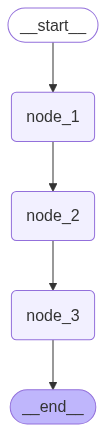

In [33]:
from IPython.display import Image, display
# draw_mermaid方法可以打印出Graph的mermaid代码。
display(Image(graph.get_graph().draw_mermaid_png()))

可以看到，一个Graph中，可以通过对Node和Edge的灵活组合，形成各种复杂的流程。接下来，我们就是要接入Agent，来完成各种复杂的任务。
在构建复杂任务之前，我们先来仔细看看Graph中的这三个主要组件。

# 1、State 状态

State是所有节点共享的状态，它是一个字典，包含了所有节点的状态。有几个需要注意的地方：

- State形式上，可以是TypedDict字典，也可以是Pydantic中的一个BaseModel。例如：

In [ ]:
from pydantic import BaseModel
def OverallState(BaseModel):
    foo: str
    user_input: str
    graph_output: str
    

也可以用 Pydantic的BaseModel 进行创建

State中的属性，除了可以修改值之外，也可以定义一些操作。来指定如何更新State中的值。例如

In [ ]:
from operator import add
from typing import List
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[List[AnyMessage], add_messages]
    list_field: Annotated[List[int], add]
    extra_field: int

此时，如果有一个node，返回了State中更新的值，那么messages和list_field的值就会添加到原有的旧集合中，而extra_field的值则会被替换。

In [35]:
from langchain_core.messages import AnyMessage, AIMessage
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from typing import Annotated, TypedDict
from operator import add
from typing import List

class State(TypedDict):
    messages: Annotated[List[AnyMessage], add_messages]
    list_field: Annotated[List[int], add]
    extra_field: int

def node1(state: State):
    new_message = AIMessage("Hello!")
    return {"messages": [new_message], "list_field": [10], "extra_field": 10}

def node2(state: State):
    new_message = AIMessage("LangGraph!")
    return {"messages": [new_message], "list_field": [20], "extra_field": 20}

graph = (StateGraph(State)
         .add_node("node1", node1)
         .add_node("node2", node2)
         .set_entry_point("node1")
         .add_edge("node1", "node2")
         .compile())

input_message = {"role": "user", "content": "Hi"}

result = graph.invoke({"messages": [input_message], "list_field": [1, 2, 3]})
print(result)

# for message in result["messages"]:
#     message.pretty_print()
# print(result["extra_field"])

{'messages': [HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}, id='94e96c9c-0fef-4396-9982-f21f50b8b06d'), AIMessage(content='Hello!', additional_kwargs={}, response_metadata={}, id='dff5b35e-9fc4-42b6-92dd-fd7782079be1'), AIMessage(content='LangGraph!', additional_kwargs={}, response_metadata={}, id='3dcf0ee5-dca5-462a-bc56-440192e0968e')], 'list_field': [1, 2, 3, 10, 20], 'extra_field': 20}


在LangGraph的应用当中，State通常都会要保存聊天消息。为此，LangGraph中还提供了一个langgraph.graph.MessageState，可以用来快速保存消息。他的声明方式就是这样的：



In [ ]:
class MessagesState(TypedDict):
    messages: Annotated[List[AnyMessage], add_messages]

然后，对于Messages，也可以用序列化的方式来声明，例如下面两种方式都是可以的
{"messages": [HumanMessage(content="message")]}
{"messages": [{"type": "human", "content": "message"}]}

# 2、Node 节点

Node是图中的一个处理数据的节点。也有以下几个需要注意的地方：

- 在LangGraph中，Node通常是一个Python的函数，它接受一个State对象作为输入，返回一个State对象作为输出。
- 每个Node都有一个唯一的名称，通常是一个字符串。如果没有提供名称，LangGraph会自动生成一个和函数名一样的名称。
- 在具体实现时，通常包含两个具体的参数，第一个是State，这个是必选的。第二个是一个可选的配置项config。这里面包含了一些节点运行的配置参数。
- LangGraph对每个Node提供了缓存机制。只要Node的传入参数相同，LangGraph就会优先从缓存当中获取Node的执行结果。从而提升Node的运行速度。

In [36]:
import time
from langchain_core.runnables import RunnableConfig
from langgraph.constants import START, END
from langgraph.graph import StateGraph
from langgraph.types import CachePolicy
from langgraph.cache.memory import InMemoryCache  # 是langgraph中的，而不是langchain中的。

# 配置状态
class State(TypedDict):
    number: int
    user_id: str

# 配置信息
class ConfigSchema(TypedDict):
    user_id: str

def node_1(state: State, config: RunnableConfig):
    time.sleep(3)
    user_id = config["configurable"]["user_id"]
    return {"number": state["number"] + 1, "user_id": user_id}

builder = StateGraph(State, config_schema=ConfigSchema)
# Node缓存5秒
builder.add_node("node1", node_1, cache_policy=CachePolicy(ttl=5))

builder.add_edge(START, "node1")
builder.add_edge("node1", END)

graph = builder.compile(cache=InMemoryCache())
print(graph.invoke({"number": 5}, config={"configurable": {"user_id": "123"}}, stream_mode='updates'))
# [{'node': {'number': 6, 'user_id': '123'}}]
# node入参相同，就会走缓存
print(graph.invoke({"number": 5}, config={"configurable": {"user_id": "456"}}, stream_mode='updates'))
# [{'node': {'number': 6, 'user_id': '123'}, '_metadata_': {'cached': True}}]

[{'node1': {'number': 6, 'user_id': '123'}}]
[{'node1': {'number': 6, 'user_id': '123'}, '__metadata__': {'cached': True}}]


- 对于Node，LangGraph除了提供缓存机制，还提供了重试机制。
  可以针对单个节点指定，例如：

from langgraph.types import RetryPolicy
builder.add_node("node1", node_1, retry=RetryPolicy(max_attempts=4))

另外，也可以针对某一次任务调用指定，例如

print(graph.invoke(xxxxxx, config={"recursion_limit":25}))

# 3、Edge 边

在Graph图中，通过Edge(边)把Node(节点)连接起来，从而决定State应该如何在Graph中传递。LangGraph中也提供了非常灵活的创建方式。

- 普通Edge和EntryPoint
  Edge通常是用来把两个Node连接起来，形成逻辑处理路线。例如 `graph.add_edge("node_1","node_2")`。
  LangGraph中提供了两个默认的Node，START和END，用来作为Graph的入口和出口。
 同时，也可以自行指定EntryPoint。例如
builder = StateGraph(State)
builder.set_entry_point("node1") 图的入口
builder.set_finish_point("node2") 图的出口

- 条件Edge和EntryPoint
我们也可以添加带有条件判断的Edge和EntryPoint，用来动态构建更复杂的工作流程。
具体实现时，可以指定一个函数，函数的返回值就可以是下一个Node的名称。

In [ ]:
from langchain_core.runnables import RunnableConfig
from langgraph.constants import START, END
from langgraph.graph import StateGraph

# 配置状态
class State(TypedDict):
    number: int

def node_1(state: State, config: RunnableConfig):
    return {"number": state["number"] + 1}

builder = StateGraph(State)
# Node缓存5秒
builder.add_node("node1", node_1)

def routing_func(state: State) -> str:
    if state["number"] > 5:
        return "node1"
    else:
        return END

builder.add_edge(START, END)
builder.add_conditional_edges(START, routing_func)

graph = builder.compile()
print(graph.invoke({"number": 4}))



In [ ]:
# 补充看一下Graph的结构
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

另外，如果不想在路由函数中写入过多具体的节点名称，也可以在函数中返回一个自定义的结果，然后将这个结果解析到某一个具体的Node上。例如


In [ ]:
def routing_func (state:State) -> bool:
    if state["number"] > 5:
        return True
    else:
        return False

builder.add_conditional_edges(START, routing_func,{True: "node_a", False: "node_b"})

- Send动态路由
在路由中，如果希望一个Node后同时路由到多个Node，就可以返回Send动态路由的方式实现。
Send对象可传入两个参数，第一个是下一个Node的名称，第二个是Node的输入。

In [37]:
from operator import add
from typing import TypedDict, Annotated

from langgraph.constants import START, END
from langgraph.graph import StateGraph
from langgraph.types import Send

# 配置状态
class State(TypedDict):
    messages: Annotated[list[str], add]

class PrivateState(TypedDict):
    msg: str

def node_1(state: PrivateState) -> State:
    res = state["msg"] + "!"
    return {"messages": [res]}

builder = StateGraph(State)
# Node缓存5秒
builder.add_node("node1", node_1)

def routing_func(state: State):
    result = []
    for message in state["messages"]:
        result.append(Send("node1", {"msg": message}))
    return result

# 通过路由函数，将消息中每个字符串分别传入node1处理。
builder.add_conditional_edges(START, routing_func, ["node1"])
builder.add_edge("node1", END)

graph = builder.compile()
print(graph.invoke({"messages": ["hello", "world", "hello", "graph", "hello!", "graph!"]}))
#{'messages': ['hello', 'world', 'hello', 'graph', 'hello!', 'graph!']}


{'messages': ['hello', 'world', 'hello', 'graph', 'hello!', 'graph!', 'hello!', 'world!', 'hello!', 'graph!', 'hello!!', 'graph!!']}


# Command命令
通常，Graph中一个典型的业务步骤是State进入一个Node处理。在Node中先更新State状态，然后再通过Edges传递给下一个Node。如果希望将这两个步骤合并为一个命令，那么还可以使用Command命令。

In [ ]:
from operator import add
from typing import TypedDict, Annotated

from langgraph.constants import START, END
from langgraph.graph import StateGraph
from langgraph.types import Command

# 配置状态
class State(TypedDict):
    messages: Annotated[list[str], add]

def node_1(state: State):
    new_message = []
    for message in state["messages"]:
        new_message.append( message + "!")
    return Command(
        goto=END,
        update={"messages":new_message}
    )

builder = StateGraph(State)
builder.add_node("node1", node_1)
# node1中通过Command同时集成了更新State和指定下个Node
builder.add_edge(START, "node1")

graph = builder.compile()
print(graph.invoke({"messages": ["hello", "world", "hello", "graph", "hello!", "world!", "graph!"]}))
# {"messages": ['hello', 'world', 'hello', 'graph', 'hello!', 'world!', 'graph!']}




# 子图
在LangGraph中，一个Graph除了可以单独使用，还可以作为一个Node嵌入到另一个Graph中。这种用法就称为子图。通过子图，我们可以更好的重用Graph，构建更复杂的工作流。尤其在构建多Agent时非常有用。在大型项目中，通常都是由一个团队专门开发Agent，再通过其他团队来完整Agent整合。
使用子图时，基本和使用Node没有太多的区别。
唯一需要注意的是，当触发了SubGraph代表的Node后，实际上是相当于重新调用了一次subgraph.invoke(state)方法。



In [ ]:
# subgraph与graph使用相同State
from operator import add
from typing import TypedDict, Annotated

from langgraph.constants import END
from langgraph.graph import StateGraph, MessagesState, START

class State(TypedDict):
    messages: Annotated[list[str], add]

# Subgraph
def sub_node_1(state: State) -> MessagesState:
    return {"messages": ["response from subgraph"]}

subgraph_builder = StateGraph(State)
subgraph_builder.add_node("sub_node_1", sub_node_1)
subgraph_builder.add_edge(START, "sub_node_1")
subgraph_builder.add_edge("sub_node_1", END)

subgraph = subgraph_builder.compile()

# Parent graph
builder = StateGraph(State)
builder.add_node("subgraph_node", subgraph)
builder.add_edge(START, "subgraph_node")
builder.add_edge("subgraph_node", END)
graph = builder.compile()

print(graph.invoke({"messages": ["hello subgraph"]}))
# 结果hello subgraph会出现两次。这是因为subgraph_node中默认调用了一次subgraph.invoke(state)方法。主图里也调用了一次invoke。这就往state中添加两次语句
#{'messages': ['hello subgraph', 'hello subgraph', 'response from subgraph']}

5、图的Stream支持

和调用大模型相似，Graph除了可以通过invoke方法进行直接调用外，也支持通过stream()方法进行流式调用。不过大模型的流式调用是依次返回大模型响应的Token。而Graph的流式输出则是依次返回State的数据处理步骤。
graph提供了stream()方法进行同步的流式调用，也提供了astream()方法进行异步的流式调用。

In [ ]:
for chunk in graph.stream({"messages": ["hello subgraph"]}, stream_mode="debug"):
    print(chunk)
# {'subgraph_node': {'messages': ['hello subgraph', 'response from subgraph']}}

LangGraph支持几种不同的stream mode：
values: 在图的每一步之后流式传输状态的完整值。
updates: 在图的每一步之后，将更新内容流式传输到状态。如果在同一步骤中进行了多次更新（例如，运行了多个节点），这些更新将分别进行流式传输。
custom: 从图节点内部流式传输自定义数据。通常用于调试。
messages: 从任何调用大语言模型（LLM）的图节点中，流式传输二元组（LLM的Token，元数据）
debug: 在图的执行过程中尽可能多地传输信息。用得比较少。
values、updates、debug输出模式，使用之前案例验证，就能很快感受到其中的区别。

In [38]:


from typing import TypedDict
from langgraph.config import get_stream_writer
from langgraph.graph import StateGraph, START

class State(TypedDict):
    query: str
    answer: str

def node(state: State):
    writer = get_stream_writer()
    writer({"自定义key": "在节点内返回自定义信息"})
    return {"answer": "some data"}

graph = (
    StateGraph(State)
    .add_node(node)
    .add_edge(START, "node")
    .compile()
)

inputs = {"query": "example"}

# Usage
for chunk in graph.stream(inputs, stream_mode="custom"):
    print(chunk)

{'自定义key': '在节点内返回自定义信息'}


五、总结

在这一章节，我们详细演练了LangGraph中的Graph构建以及工作方式。可以看到，Graph图的构建非常灵活，我们可以自由地构建各种复杂的图结构。即使是没有与大模型交互的图，也可以通过LangGraph来构建。这对于处理传统任务也是非常有用的。

当然，LangGraph中的图，还是要有大模型的加持，才能更好的体现他们的强大之处。下一章节我们就着重去演练大模型加持下的LangGraph。

在这里，不妨回顾一下LangChain中的Chain是如何构建的，并与Graph做一下对比。可以看到，这两个框架都是着眼于将多个独立的功能模块组合进行调度、组合，形成复杂的智能体。只不过，LangChain使用的是Chain的方式，而LangGraph是使用Graph的方式。或许这样能够更好的体会到，为什么LangGraph是LangChain的一个子项目，而不是一个独立的框架了。



# 五、使用LangGraph构建多智能体工作流


上一章节我们在没有大模型的加持下，全面演练了LangGraph的Graph图结构。这一章节，就结合大模型，来深入理解LangGraph如何通过Graph构建复杂的大模型应用。

## 一、流式输出大模型调用结果

在介绍Graph的流式输出时，我们提到LangGraph的Graph流式输出有几种不同的模式，其中有一种messages模式，是用来监控大语言模型的Token记录的。这里我们就可以来测试一下。

In [ ]:
from langchain_community.chat_models import ChatTongyi
llm = LLMFactory.create_llm()
# 构建阿里云百炼大模型客户端

from langgraph.graph import StateGraph, MessagesState, START
from langgraph.checkpoint.memory import InMemorySaver

def call_model(state: MessagesState):
    response = llm.invoke(state["messages"])
    return {"messages": response}

builder = StateGraph(MessagesState)
builder.add_node(call_model)
builder.add_edge(START, "call_model")

graph = builder.compile()

for chunk in graph.stream(
        {"messages": [{"role": "user", "content": "湖南的省会是哪里？"}]},
        stream_mode="messages",
):
    print(chunk)

# 二、大模型消息持久化

和之前介绍LangGraph的Agent相似，Graph图也支持构建消息的持久化功能。并且也通常支持通过checkpoint构建短期记忆，以store构建长期记忆。
这里短期记忆和长期记忆，都是可以通过内存或者数据库进行持久化保存的。不过短期记忆更倾向于通过对消息的短期存储，实现多轮对话的效果。而长期记忆则倾向于对消息长期存储后支持语义检索。

In [ ]:
from langchain_community.chat_models import ChatTongyi
from langgraph.graph import StateGraph, MessagesState, START
from langgraph.checkpoint.memory import InMemorySaver

def call_model(state: MessagesState):
    response = llm.invoke(state["messages"])
    return {"messages": response}

builder = StateGraph(MessagesState)
builder.add_node(call_model)
builder.add_edge(START, "call_model")

checkpointer = InMemorySaver()
graph = builder.compile(checkpointer=checkpointer)

config = {
    "configurable": {
        "thread_id": "1"
    }
}

for chunk in graph.stream(
        input = {"messages": [{"role": "user", "content": "湖南的省会是哪里？"}]},
        config = config,
        stream_mode="values",
):
    chunk["messages"][-1].pretty_print()

for chunk in graph.stream(
        input = {"messages": [{"role": "user", "content": "湖北呢？"}]},
        config = config,
        stream_mode="values",
):
    chunk["messages"][-1].pretty_print()


三、Human-In-Loop人类干预

在LangGraph中也可以通过中断任务，等待确认的方式，来实现过程干预，这样能够更好的减少大语言模型的结果不稳定给任务带来的影响。

在具体实现人类干预时，需要注意一下几点：
- 必须指定一个checkpoint短期记忆，否则无法保存任务状态。
- 在执行Graph任务时，必须指定一个带有thread_id的配置项，指定线程ID。之后才能通过线程ID，指定恢复线程。
- 在任务执行过程中，通过interrupt()方法，中断任务，等待确认。
- 在人类确认之后，使用Graph提交一个resume=True的Command指令，恢复任务，并继续进行。

这种实现方式，在之前介绍LangGraph构建单取块时已经介绍过，不过，结合Graph的State，在多个Node之间进行复杂控制，这样更能体现出人类监督的价值。

例如，下面的案例可以实现这样一种典型的人类确认：

In [ ]:
from langchain_core.messages import AnyMessage
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.constants import START, END
from langgraph.graph import StateGraph

from langchain_community.chat_models import ChatTongyi
# 构建阿里云百炼大模型客户端

from typing import Literal, TypedDict, Annotated
from langgraph.types import interrupt, Command

class State(TypedDict):
    messages: Annotated[list[AnyMessage], add]

def human_approval(state: State) -> Command[Literal["call_llm", END]]:
    is_approved = interrupt(
        {
            "question": "是否同意调用大语言模型？"
        }
    )

    if is_approved:
        return Command(goto="call_llm")
    else:
        return Command(goto=END)

def call_llm(state: State):
    response = llm.invoke(state["messages"])
    return {"messages": [response]}

builder = StateGraph(State)
# Add the node to the graph in an appropriate location
# and connect it to the relevant nodes.
builder.add_node("human_approval", human_approval)
builder.add_node("call_llm", call_llm)

builder.add_edge(START, "human_approval")

checkpointer = InMemorySaver()

graph = builder.compile(checkpointer=checkpointer)


In [ ]:
from langchain_core.messages import HumanMessage

# 提交任务，等待确认
thread_config = {"configurable": {"thread_id": 1}}
graph.invoke({"messages": [HumanMessage("湖南的省会是哪里？")]}, config=thread_config)
# 执行后会中断任务，等待确认

In [ ]:
# 确认同意，继续执行任务
final_result = graph.invoke(Command(resume=True), config=thread_config)
print(final_result)
# 不同意，终止任务
# final_result = graph.invoke(Command(resume=False), config=thread_config)
# print(final_result)

注意：
- 任务中断和恢复，需要保持相同的thread_id。通常应用当中都会单独生成一个随机的thread_id，保证唯一的同时，防止其他任务干扰。
- interrupt()方法中断任务的时间不能过长，过长了之后就无法恢复任务了。
- 任务确认时，Command中传递的resume可以是简单的True或False，也可以是一个字典。通过字典可以进行更多的判断。

四、Time Travel时间回溯

由于大语言模型回答问题的不确定性，基于大语言模型构建的应用，也是充满不确定性的。而对于这种不确定性的系统，就有必要进行更精确的检查。当某一个步骤出现问题时，才能及时发现问题，并将问题的那个步骤进行重演。为此，LangGraph提供了Time Travel时间回溯功能，可以保存Graph的运行过程，并可手动指定从Graph的某一个Node开始进行重演。

具体实现时，需要注意以下几点：
- 在运行Graph时，需要提供初始的输入消息。
- 运行时，指定thread_id线程ID。并且要基于这个线程ID，再指定一个checkpoint检查点。执行后将在每一个Node执行后，生成一个checkpoint_id
- 指定thread_id和checkpoint_id，进行任务重演。重演前，可以选择更新state，当然，如果没问题，也可以不指定。

In [ ]:
# 构建一个图。图中两个步骤：第一步让大模型推荐一个有名的作家，第二步，让大模型用推荐的作家的风格写一个100字以内的笑话。
from typing import TypedDict
from typing_extensions import NotRequired
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.constants import START, END
from langgraph.graph import StateGraph
from langchain_community.chat_models import ChatTongyi
# 构建阿里云百炼大模型客户端

class State(TypedDict):
    author: NotRequired[str]
    joke: NotRequired[str]

def author_node(state: State):
    prompt = "帮我推荐一位受人们欢迎的作家。只需要给出作家的名字即可。"
    author = llm.invoke(prompt)
    return {"author": author}

def joke_node(state: State):
    prompt = f"用作家: {state['author']} 的风格写一个100字以内的笑话"
    joke = llm.invoke(prompt)
    return {"joke": joke}

builder = StateGraph(State)
builder.add_node(author_node)
builder.add_node(joke_node)
builder.add_edge(START, "author_node")
builder.add_edge("author_node", "joke_node")
builder.add_edge("joke_node", END)

checkpointer = InMemorySaver()
graph = builder.compile(checkpointer=checkpointer)

In [ ]:
# 正常执行一个图
import uuid

config = {
    "configurable": {
        "thread_id": uuid.uuid4(),
    }
}
state = graph.invoke({}, config)

print(state["author"])
print()
print(state["joke"])

In [ ]:
# 查看所有checkpoint检查点
states = list(graph.get_state_history(config))

for state in states:
    print(state.next)
    print(state.config["configurable"]["checkpoint_id"])
    print()

In [ ]:
# 选定某一个检查点。这里选择author_node，让大模型重新推荐作家
selected_state = states[1]
print(selected_state.next)
print(selected_state.values)

In [ ]:
# 为了后面的重演，更新state。可选步骤：
new_config = graph.update_state(selected_state.config, values={"author": "郭德纲"})
print(new_config)

In [ ]:
# 接下来，指定thread_id和checkpoint_id，进行重演
graph.invoke(None, new_config)

五、多智能体架构

可以看到，在LangChain体系中，LangChain主要集成了和大语言模型交互的能力，而LangGraph主要实现了复杂的流程调度。将这两个能力结合起来，一个强大的多智能体构建框架就已经成型了。

接下来，我们就用LangGraph来实现一个非常典型的多智能体架构，作为一个完整的案例。
- 这个机器人可以通过一个supervisor节点，对用户的输入进行分类，然后根据分类结果，选择不同的agent节点进行处理。
- 接下来每个agent节点，都可以选择不同的工具进行处理，最后将处理结果汇总，返回给supervisor节点。
- supervisor节点再将结果返回给用户。